## Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
import tensorflow_hub as hub

## Data Pre-Processing

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/'

In [ ]:
df = pd.read_csv(base_path + 'datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['img_path'] = base_path + 'datasets/train/images/' + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [ ]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_count = 1200
df_balanced = pd.DataFrame(columns=df.columns)

for label in classes:
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipython-input-10-3466899084.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_balanced = pd.concat([df_balanced, df_class_balanced])


In [ ]:
len(df)

8400

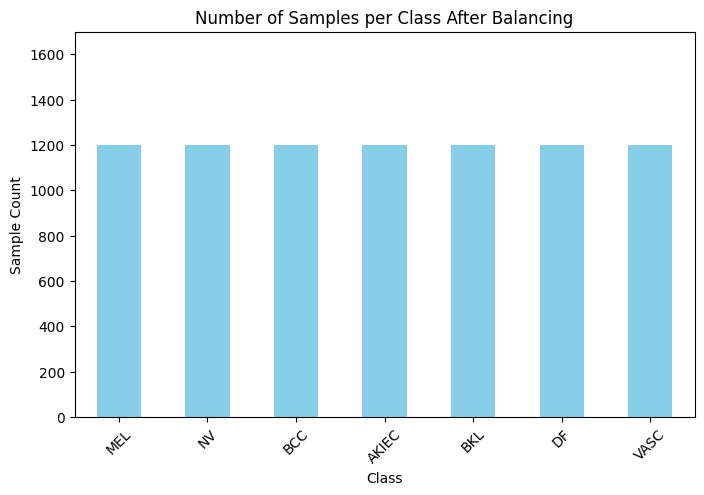

In [ ]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [ ]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training:
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [ ]:
df_validate = pd.read_csv(base_path + 'datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = base_path + 'datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv(base_path + 'datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = base_path + 'datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [ ]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

### Vision Transformer (ViT)

In [ ]:
def cnn_branch(inputs):

  base_model = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
    )

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  return x

In [ ]:
def vit_layer(img, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    # Patch creation
    patch_size = 16
    num_patches = (img.shape[1] // patch_size) ** 2
    projection_dim = ff_dim

    x = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(img)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + pos_embedding

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Layer Norm 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        x2 = layers.Add()([x, attention_output])

        # Layer Norm 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ff_output = layers.Dense(ff_dim, activation='relu')(x3)
        ff_output = layers.Dense(projection_dim)(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.Add()([x2, ff_output])

    # Global representation
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    return x


In [ ]:
def build_model(hp):
    num_classes = 7

    num_heads = hp.Choice('vit_num_heads', [4, 6, 8])
    ff_dim = hp.Choice('vit_ff_dim', [128, 256, 512])
    num_transformer_blocks = hp.Int('vit_num_blocks', 1, 4)
    vit_dropout = hp.Float('vit_dropout', 0.1, 0.5, step=0.1)

    inputs = layers.Input(shape=(224, 224, 3))
    cnn_features = cnn_branch(inputs)
    vit_features = vit_layer(inputs, num_heads, ff_dim, num_transformer_blocks, vit_dropout)

    fused = layers.Concatenate()([cnn_features, vit_features])

    x = layers.Dense(hp.Int('dense_1_units', min_value=512, max_value=2048, step=256), activation='relu')(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1))(x)

    x = layers.Dense(hp.Int('dense_2_units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.7, step=0.1))(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    learning_rate = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='vit_tuner',
    project_name='skin_lesion'
)

Reloading Tuner from vit_tuner/skin_lesion/tuner0.json


In [ ]:
tuner.search(df_train, epochs=6, validation_data=df_validate)
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 24m 30s]
val_accuracy: 0.8238341808319092

Best val_accuracy So Far: 0.8497409224510193
Total elapsed time: 07h 13m 08s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1298 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
print("Best Hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
vit_num_heads: 4
vit_ff_dim: 512
vit_num_blocks: 2
vit_dropout: 0.5
dense_1_units: 1280
dropout_1: 0.30000000000000004
dense_2_units: 512
dropout_2: 0.30000000000000004
learning_rate: 3.009994689039283e-05
